In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from EOS_Solver import EoSNetwork
import matplotlib.pyplot as plt
from TOV_Solver import WaveNetTOV
from preprocessing import eos_load_and_preprocess

Using device: cuda


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Input Data

In [3]:
observed_mr = pd.read_csv("data/sample_mr.csv")
observed_eos = pd.read_csv("data/sample_eos.csv")

# ---------------- M–R preprocessing (same as before) ----------------
M_MAX = observed_mr.query("ID != 19248")["M"].max()
R_MAX = 16.0
R_MIN = observed_mr.query("ID != 19248")["R"].min()

observed_mr = observed_mr.query("ID == 19248").query("model == 'RMFNL'")
M_targets = np.linspace(1.0, min(2.25, observed_mr["M"].max()), 11)

M_values = observed_mr["M"].values
R_values = observed_mr["R"].values

R_obs = np.array([R_values[np.argmin(np.abs(M_values - m))] for m in M_targets])

M_scaled = M_targets / M_MAX
R_scaled = (R_obs - R_MIN) / (R_MAX - R_MIN)

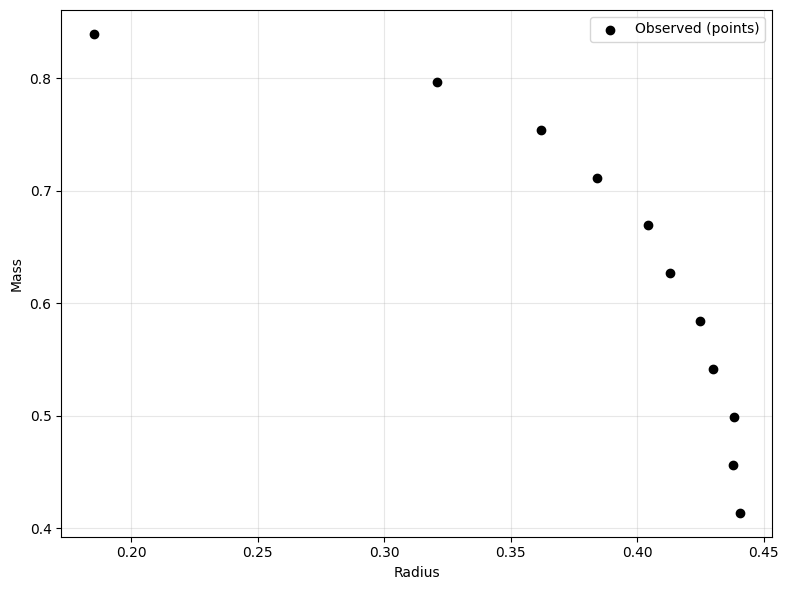

In [4]:
# --- Plot ---
plt.figure(figsize=(8, 6))
plt.scatter(R_scaled, M_scaled, color="black", label="Observed (points)", zorder=3)
plt.xlabel("Radius")
plt.ylabel("Mass")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

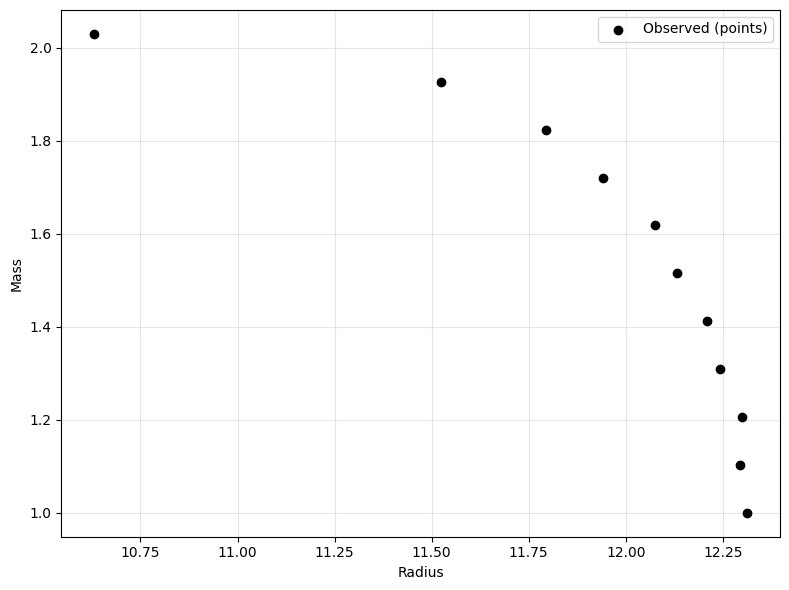

In [5]:
# --- Plot ---
plt.figure(figsize=(8, 6))
plt.scatter(R_obs, M_targets, color="black", label="Observed (points)", zorder=3)
plt.xlabel("Radius")
plt.ylabel("Mass")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Results

In [6]:
# Load TOV-Solver Network
tov = WaveNetTOV().to(device)
tov.load_state_dict(torch.load("models/tov_solver.pt", map_location=device))
tov.eval()

# Load EoS Network
eos = EoSNetwork().to(device)
eos.load_state_dict(torch.load("models/eos_solver.pt", map_location=device))
eos.eval()


EoSNetwork(
  (act): ELU(alpha=1.0)
  (conv1): ParametrizedConv1d(
    1, 128, kernel_size=(1,), stride=(1,)
    (parametrizations): ModuleDict(
      (weight): ParametrizationList(
        (0): NonNegative()
      )
    )
  )
  (conv2): ParametrizedConv1d(
    128, 128, kernel_size=(1,), stride=(1,)
    (parametrizations): ModuleDict(
      (weight): ParametrizationList(
        (0): NonNegative()
      )
    )
  )
  (conv3): ParametrizedConv1d(
    128, 64, kernel_size=(1,), stride=(1,)
    (parametrizations): ModuleDict(
      (weight): ParametrizationList(
        (0): NonNegative()
      )
    )
  )
  (conv4): ParametrizedConv1d(
    64, 1, kernel_size=(1,), stride=(1,)
    (parametrizations): ModuleDict(
      (weight): ParametrizationList(
        (0): NonNegative()
      )
    )
  )
)

In [7]:
rho_scaled, M_obs_scaled, R_obs_scaled, dM, dR = eos_load_and_preprocess("data/sample_mr.csv", "data/sample_eos.csv", 32, device)

M_scaled: [0.41831693 0.6645101  0.74158062 0.78460618 0.8117416  0.82812586
 0.83673261 0.83925236 0.83664035 0.82981553 0.81926079]
R_scaled: [0.44090759 0.40409192 0.36727626 0.3304606  0.29364493 0.25682927
 0.22001361 0.18319794 0.14638228 0.10956662 0.07275095]
rho_scaled: [0.         0.00322581 0.00645161 0.00967742 0.01290322 0.01612903
 0.01935484 0.02258065 0.02580645 0.02903226 0.03225806 0.03548387
 0.03870967 0.04193548 0.04516129 0.0483871  0.0516129  0.05483871
 0.05806452 0.06129032 0.06451613 0.06774194 0.07096774 0.07419354
 0.07741936 0.08064516 0.08387096 0.08709677 0.09032258 0.09354838
 0.09677419 0.1       ]


In [8]:
rho_t = torch.tensor(rho_scaled, dtype=torch.float32, device=device).reshape(1, -1, 1)
p_pred = eos(rho_t)
p_pred

tensor([[[0.2038],
         [0.2149],
         [0.2274],
         [0.2415],
         [0.2573],
         [0.2746],
         [0.2931],
         [0.3128],
         [0.3336],
         [0.3558],
         [0.3793],
         [0.4041],
         [0.4304],
         [0.4584],
         [0.4881],
         [0.5202],
         [0.5552],
         [0.5911],
         [0.6260],
         [0.6598],
         [0.6920],
         [0.7225],
         [0.7511],
         [0.7778],
         [0.8027],
         [0.8258],
         [0.8474],
         [0.8679],
         [0.8880],
         [0.9086],
         [0.9306],
         [0.9528]]], device='cuda:0', grad_fn=<PermuteBackward0>)

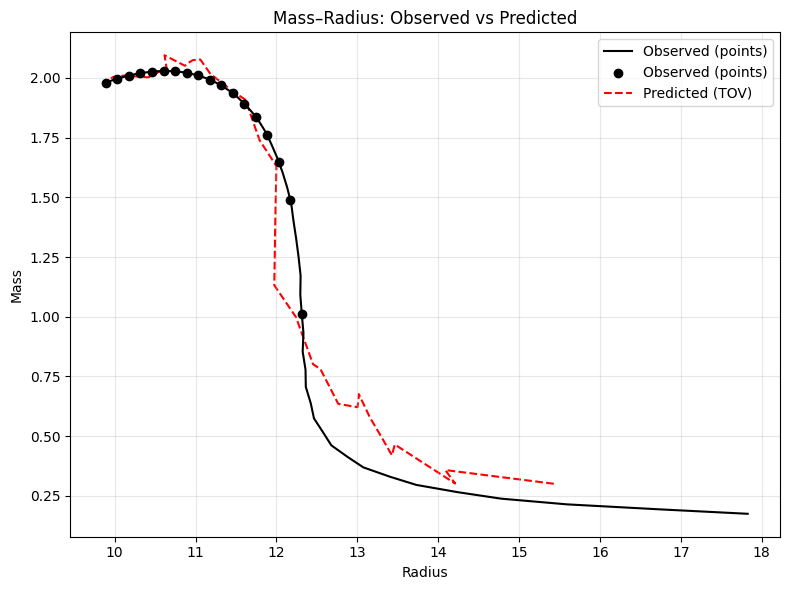

In [9]:
observed_mr = pd.read_csv("data/sample_mr.csv")
observed_eos = pd.read_csv("data/sample_eos.csv")

# ---------------- global scaling constants (must match TOV training) ----------------
# These should be computed the same way as in tov_load_and_preprocess: ID != 19248
M_MAX = observed_mr.query("ID != 19248")["M"].max()
R_MAX = 16.0
R_MIN = observed_mr.query("ID != 19248")["R"].min()

# ---------------- M–R for the "observed" curve (ID 19248, RMFNL) ----------------
mr_19248 = observed_mr.query("ID == 19248").query("model == 'RMFNL'")

# assume rows are ordered along the physical sequence (central density)
M_values = mr_19248["M"].values.astype(np.float32)
R_values = mr_19248["R"].values.astype(np.float32)

# --------- find R(M = 1) on the *stable* branch ---------
# stable branch: from start up to maximum mass
imax = np.argmax(M_values)                 # index of M_max
M_stable = M_values[:imax + 1]
R_stable = R_values[:imax + 1]

# interpolate R at M = 1 on the stable branch (this is your R_max_phys)
R_at_M1 = np.interp(1.0, M_stable, R_stable)

# --------- restrict to region with M >= 1.0 (stable + unstable if present) ---------
mask_M_ge_1 = M_values >= 1.0
M_ge1 = M_values[mask_M_ge_1]
R_ge1 = R_values[mask_M_ge_1]

# smallest radius that still has M >= 1.0
R_min_phys = R_ge1.min()

# we'll interpolate M as a function of R, so sort this subset by R
order_R = np.argsort(R_ge1)                # ascending R
R_ge1_sorted = R_ge1[order_R]
M_ge1_sorted = M_ge1[order_R]

# --------- choose 11 radii between R(M=1) and R_min_phys ---------
R_targets = np.linspace(
    R_at_M1,       # "R_max" = radius at M = 1
    R_min_phys,    # "R_min" = most compact star with M >= 1
    18,
    dtype=np.float32
)

# interpolate M(R) along this monotonic R-sorted branch
M_targets = np.interp(R_targets, R_ge1_sorted, M_ge1_sorted)

# these are your 11 observed points
R_obs = R_targets

# Observed M–R (in physical units)
mass_obs = M_targets
radius_obs = R_obs

#predictions
mr_relation_pred = tov(p_pred)

# Convert torch tensor → NumPy
mr_pred_flat = mr_relation_pred.detach().cpu().numpy().squeeze()
mass_pred = mr_pred_flat[:, 0] * M_MAX
radius_pred = mr_pred_flat[:, 1] * (R_MAX - R_MIN) + R_MIN

# --- Plot ---
plt.figure(figsize=(8, 6))
plt.plot(observed_mr.query("ID == 19248").query("model == 'RMFNL'")["R"].values, 
        observed_mr.query("ID == 19248").query("model == 'RMFNL'")["M"].values, color="black", label="Observed (points)", zorder=3)
plt.scatter(radius_obs, mass_obs, color="black", label="Observed (points)", zorder=3)
plt.plot(radius_pred, mass_pred, "--", color="red", label="Predicted (TOV)", zorder=1)
plt.xlabel("Radius")
plt.ylabel("Mass")
plt.title("Mass–Radius: Observed vs Predicted")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()